# Generating trajectories using quantum state diffusion. We will be primairly interested in the absorptive bistability (Jaynes Cummings model)

I store trajectory files as *.pkl files or *.mat files. This way I can easily load them into another notebook, or load the trajectories to matlab.

See also diffusion_maps/make_quantum_trajectories_absorptive_bistability

In [3]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [4]:
####
####

### Current implemented regime is "absorptive_bistable"
### TODO: implement other regimes.

Regime = "absorptive_bistable"
file_name = './trajectory_data/QSD_' + Regime

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True
## pkl file (can be loaded in python) in the same format as above.
save_pkl = True

####
####

In [5]:
import matplotlib as mil
mil.use('TkAgg')

In [6]:
## QHDL package
from qnet.algebra.operator_algebra import *
from qnet.algebra.circuit_algebra import *
import qnet.algebra.state_algebra as sa

from sympy import sqrt

## SDE integrator
import sdeint

## quantum state diffusion solver
from quantum_state_diffusion import qsd_solve

## numerical libraries
import numpy as np
import numpy.linalg as la
from scipy import sparse

## plottinsg
import matplotlib.pyplot as plt

## pickle
import pickle

In [7]:
from save2matfile_or_pkl import save2matfile_or_pkl

In [8]:
%matplotlib inline

In [9]:
## General parameters

params = {}

ntraj = params['Ntraj'] = 10
duration = params['duration'] = 10000
delta_t = params['delta_t'] = 2e-2
Nfock_a = params['Nfock_a'] = 50
Nfock_j = params['Nfock_j'] = 2

## Make Operators

In [10]:
a = Destroy(1)
ad = a.dag()

sm = LocalSigma(2, 1,0)/sqrt(2)
sp = sm.dag()
sz = sp*sm - sm*sp 

j = Jminus(2)
jp = j.dag()
jz = Jz(2)

jx = (jp + j) / 2.
jy = (jp - j) / 2.

## Make SLH Model

In [11]:
k,g0,g = symbols("kappa, g0,gamma", positive=True)
DD, TT = symbols("Delta, Theta", real=True)
W = symbols("Omega")

L = [sqrt(k)*a, 
     sqrt(g)*j]
H = -I*g0*(a*jp - ad * j) + DD*jz + TT*ad*a
S = identity_matrix(2)

slh = SLH(S, L, H).coherent_input(W,0)
slh

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(Omega, IdentityOperator), ScalarTimesOperator(sqrt(kappa), Destroy(LocalSpace('1', ''))))], [ScalarTimesOperator(sqrt(gamma), Jminus(LocalSpace('2', '')))]]), OperatorPlus(ScalarTimesOperator(Delta, Jz(LocalSpace('2', ''))), ScalarTimesOperator(-I*g0, OperatorPlus(ScalarTimesOperator(-1, OperatorTimes(Create(LocalSpace('1', '')), Jminus(LocalSpace('2', '')))), OperatorTimes(Destroy(LocalSpace('1', '')), Jplus(LocalSpace('2', ''))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-Omega*sqrt(kappa), Create(LocalSpace('1', ''))), ScalarTimesOperator(sqrt(kappa)*conjugate(Omega), Destroy(LocalSpace('1', ''))))), ScalarTimesOperator(Theta, OperatorTimes(Create(LocalSpace('1', '')), Destroy(LocalSpace('1', ''))))))

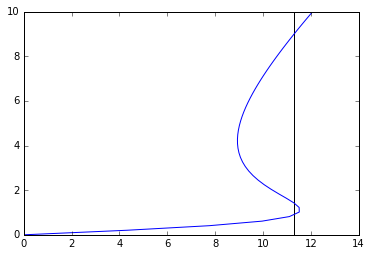

In [12]:
## Numerical parameters

a.space.dimension = Nfock_a
j.space.dimension = Nfock_j

# default are for absorptive bistability
def make_nparams(Cn=10.5, kn=.12, yn=11.3, DDn=0, TTn=0., J = 0.5):
    g0n = np.sqrt(2.*kn*Cn)
    Wn = yn*kn/np.sqrt(2)/g0n
    
    nparams = {
        W: Wn/np.sqrt(2*kn),
        k: 2*kn,
        g: 2./np.sqrt(2*J),
        g0: -g0n/np.sqrt(2*J),
        DD: DDn,
        TT: TTn,
    }
    xrs = np.linspace(0, 10)
    yrs = 2*Cn*xrs/(1+xrs**2) + xrs
    plt.plot(yrs, xrs)
    plt.vlines([yn], *plt.ylim())
    return nparams

if Regime == "absorptive_bistable":
    nparams = make_nparams()
else:
    raise ValueError("Unknown regime, or not implemented yet.")

Hq, Lqs = slh.substitute(nparams).HL_to_qutip()

In [13]:
## Observables

obs = (a, j, jz, a*a, a.dag()*a, a*jp, jp, jx, jy)
obsq = [o.to_qutip(full_space=slh.space) for o in obs]

In [14]:
tspan = np.arange(0,duration,delta_t)

In [15]:
psi0 = qutip.tensor(qutip.basis(Nfock_a,0),qutip.basis(Nfock_j,0)).data

In [16]:
H = Hq.data
Ls = [Lq.data for Lq in Lqs]
obsq = [ob.data for ob in obsq]

# Bistable Regime

In [29]:
Regime = "absorptive_bistable"
file_name = './trajectory_data/QSD_' + Regime

In [17]:
seed = [i for i in range(ntraj)]

In [18]:
H, psi0, tspan, Ls, sdeint.itoSRI2, obsq, ntraj

(<100x100 sparse matrix of type '<class 'numpy.complex128'>'
 	with 294 stored elements in Compressed Sparse Row format>,
 <100x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 array([  0.00000000e+00,   2.00000000e-02,   4.00000000e-02, ...,
          9.99994000e+03,   9.99996000e+03,   9.99998000e+03]),
 [<100x100 sparse matrix of type '<class 'numpy.complex128'>'
  	with 198 stored elements in Compressed Sparse Row format>,
  <100x100 sparse matrix of type '<class 'numpy.complex128'>'
  	with 50 stored elements in Compressed Sparse Row format>],
 <function sdeint.integrate.itoSRI2>,
 [<100x100 sparse matrix of type '<class 'numpy.complex128'>'
  	with 98 stored elements in Compressed Sparse Row format>,
  <100x100 sparse matrix of type '<class 'numpy.complex128'>'
  	with 50 stored elements in Compressed Sparse Row format>,
  <100x100 sparse matrix of type '<class 'numpy.complex128'>'
  	with 100 stored elements in Comp

In [19]:
D = qsd_solve(H, psi0, tspan, Ls, sdeint.itoEuler, obsq = obsq, ntraj = ntraj, seed = seed, normalize_state = True)

Run time:   1269.8009328842163  seconds.


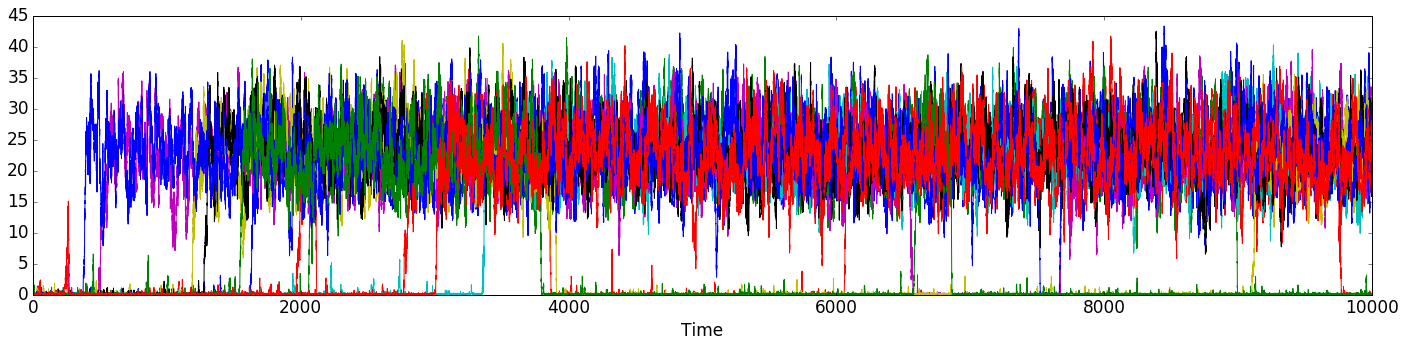

In [21]:
## Plot the observables
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(ntraj):
    plt.plot(tspan,D['obsq_expects'][t,:,4].real)

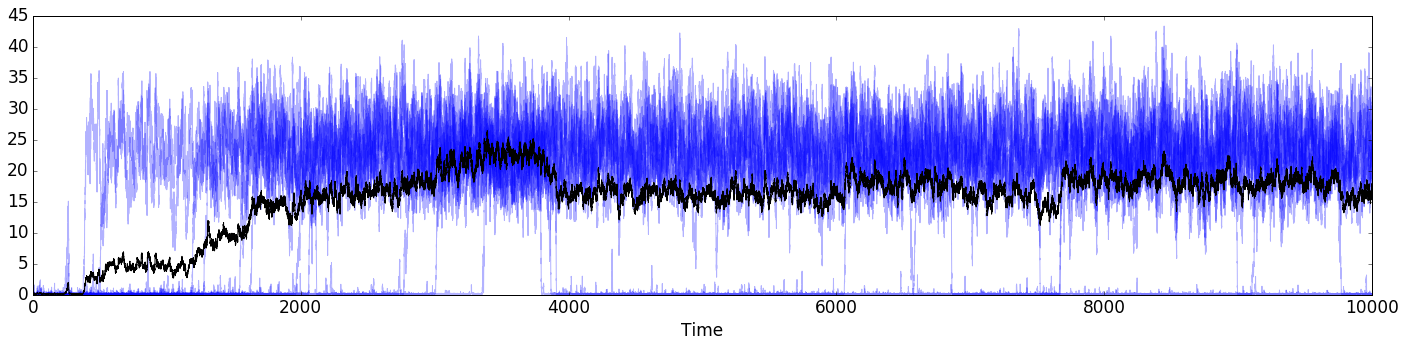

In [22]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan, D['obsq_expects'][t,:,4].real , "b", alpha=0.3)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,4].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


In [26]:
downsample = 100

In [27]:
D.update({'tspan':tspan})
D_downsampled = {'psis' : D['psis'][:,::downsample],
                 'obsq_expects' : D['obsq_expects'][:,::downsample], 
                 'seeds' : D['seeds'],
                 'tspan' : D['tspan'] }

In [30]:
save2matfile_or_pkl(D_downsampled, file_name, obs, params = {}, save_mat = save_mat, save_pkl = save_pkl)

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_absorptive_bistable.mat

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_absorptive_bistable.pkl

{'expects': array([[[ 0.00000000+0.j,  0.00000000+0.j,  0.50000000+0.j, ...,
           0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j],
         [-0.82664712+0.j, -0.42235936+0.j, -0.03354922+0.j, ...,
          -0.42235936+0.j, -0.42235936+0.j,  0.00000000+0.j],
         [-0.29430652+0.j, -0.34517491+0.j, -0.33378393+0.j, ...,
          -0.34517491+0.j, -0.34517491+0.j,  0.00000000+0.j],
         ..., 
         [-4.57982847+0.j,  0.08241300+0.j, -0.35142896+0.j, ...,
           0.08241300+0.j,  0.08241300+0.j,  0.00000000+0.j],
         [-4.72983390+0.j, -0.26027455+0.j,  0.33221308+0.j, ...,
          -0.26027455+0.j, -0.26027455+0.j,  0.00000000+0.j],
         [-4.87452904+0.j,  0.12809780+0.j, -0.06141035+0.j, ...,
           0.12809780+0.j,  0.12809780+0.j,  0.00000000+0.j]],
 
        [[ 0.00000000+0.j,  0.00000000+0.j,  0.50000000+0.j, ...,
           0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j],
         [-0.32837199+0.j, -0.27475528+0.j, -0.41751465+0.j, ...,
         